In [9]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [10]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.models as models

In [11]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

if torch.cuda.is_available():
    print("Cuda works")

class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        # Get the list of subfolders (folder names are strings)
        subfolders = sorted(os.listdir(self.root), key=lambda x: int(x))

        # Create a list of paths to the subfolders in numerical order
        subfolders_paths = [os.path.join(self.root, folder) for folder in subfolders]

        # Initialize lists to store image paths and labels
        self.samples = []

        for class_idx, folder_path in enumerate(subfolders_paths):
            class_images = [(os.path.join(folder_path, image), class_idx) for image in os.listdir(folder_path)]
            self.samples.extend(class_images)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        image_path, label = self.samples[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        if torch.cuda.is_available():
            image = image.cuda()

        return image, label

# Define the directory containing your images
data_dir = '/content/gdrive/MyDrive/CSE144_Final_Project/train/train'

size = 224
# Define the transformations to be applied to each image
transform = transforms.Compose([
    transforms.Resize((size,size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

additional_transform = transforms.Compose([
    transforms.Resize((size,size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.7, contrast=0.7),  # Adjust brightness and contrast randomly
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

additional_transform_2 = transforms.Compose([
    transforms.Resize((size,size)),
    transforms.RandomRotation(60),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

additional_transform_3 = transforms.Compose([
    transforms.Resize((size,size)),
    transforms.ColorJitter(saturation=0., hue=0.3),  # Adjust brightness and contrast randomly
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

additional_transform_4 = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.GaussianBlur(kernel_size=3),  # Adjust kernel_size as needed
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a custom dataset from the sorted subfolders
dataset = CustomImageFolder(root=data_dir, transform=transform)
add_dataset = CustomImageFolder(root=data_dir, transform=additional_transform)
add2_dataset = CustomImageFolder(root=data_dir, transform=additional_transform_2)
add3_dataset = CustomImageFolder(root=data_dir, transform=additional_transform_3)
add4_dataset = CustomImageFolder(root=data_dir, transform=additional_transform_4)


dataset.samples.extend(add_dataset.samples)
dataset.samples.extend(add2_dataset.samples)
dataset.samples.extend(add3_dataset.samples)
dataset.samples.extend(add4_dataset.samples)


# Split the dataset into training and testing sets
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

# Create data loaders for the training and testing sets
train_loader = DataLoader(dataset, batch_size=8, sampler=torch.utils.data.SubsetRandomSampler(train_indices))
test_loader = DataLoader(dataset, batch_size=8, sampler=torch.utils.data.SubsetRandomSampler(test_indices))

# print(len(train_loader))
# print(len(test_loader))

# print(dataset.samples)

Cuda works


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define your custom head
class CustomResNetHead(nn.Module):
    def __init__(self, in_features, num_classes=100):
        super(CustomResNetHead, self).__init__()
        self.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(in_features, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

# Load the pretrained ResNet-50 model
model = models.vit_b_16(pretrained=True)
# Freeze the feature layers

for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer
in_features = model.heads.head.in_features
model.heads = nn.Sequential (
    CustomResNetHead(in_features, 100)
)

# print(model)

if torch.cuda.is_available():
    model.cuda()
    model.to('cuda')

# Set up optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-5)
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
import torch.multiprocessing as mp

if __name__ == '__main__':
    mp.set_start_method('spawn', force=True)

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            # images = images.permute(0, 3, 1, 2)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training the network
num_epochs = 5
train_losses, test_losses = [], []
train_acc, test_acc = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
        #inputs = inputs.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = calculate_accuracy(train_loader, model)
    train_acc.append(train_accuracy)

    test_loss = 0.0
    for data in test_loader:
        images, labels = data
        if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
        #images = images.permute(0, 3, 1, 2)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = calculate_accuracy(test_loader, model)
    test_acc.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

Epoch 1/5, Train Loss: 4.4000, Train Acc: 73.81%, Test Loss: 4.1470, Test Acc: 63.16%
Epoch 2/5, Train Loss: 4.0447, Train Acc: 88.22%, Test Loss: 3.9539, Test Acc: 81.95%
Epoch 3/5, Train Loss: 3.9209, Train Acc: 93.05%, Test Loss: 3.8474, Test Acc: 88.97%
Epoch 4/5, Train Loss: 3.8428, Train Acc: 95.93%, Test Loss: 3.7982, Test Acc: 92.48%
Epoch 5/5, Train Loss: 3.7978, Train Acc: 96.12%, Test Loss: 3.7666, Test Acc: 92.98%


In [14]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/CSE144_Final_Project/model.pth")

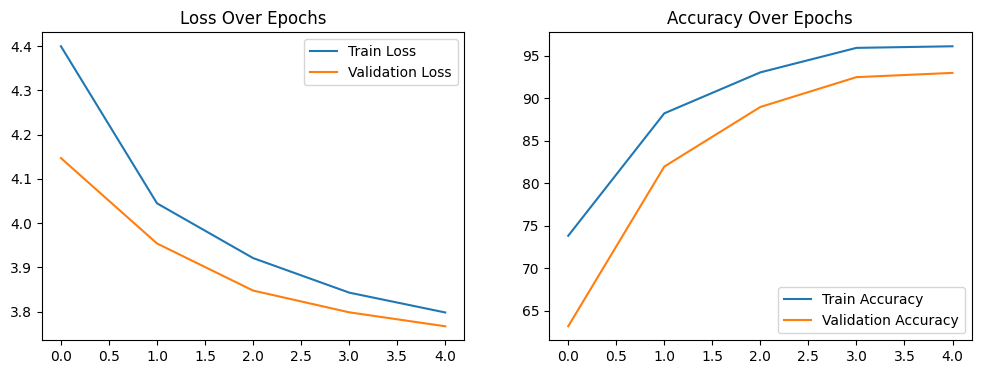

In [15]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()

In [16]:
import pandas as pd
from tqdm import tqdm

class CustomTestFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        # Get the list of image files
        image_files = sorted(os.listdir(self.root), key=lambda x: int(x[:-4]))

        # Create a list of paths to the images in alphabetical order
        self.samples = [os.path.join(self.root, image) for image in image_files]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        image_path = self.samples[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image

# Set the directory for the test images
test_data_dir = '/content/gdrive/MyDrive/CSE144_Final_Project/test/test'

# Create a custom dataset for the test set
test_transform = transforms.Compose([
    transforms.Resize((size,size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = CustomTestFolder(root=test_data_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set the model to evaluation mode and move it to the GPU
model.eval()
model.to('cuda')

# Create lists to store predictions
predictions = []

# Iterate over the test set and make predictions
for images in tqdm(test_loader, desc="Predicting"):
    with torch.no_grad():
        # Move input data to the same device as the model
        images = images.to('cuda')

        # Make predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Append predictions to the list
        predictions.extend(predicted.cpu().numpy())

# Create a DataFrame with image file names and predicted labels
image_file_names = [os.path.basename(sample) for sample in test_dataset.samples]
df = pd.DataFrame({'ID': image_file_names, 'Label': predictions})

# Save the DataFrame to a CSV file
df.to_csv('/content/gdrive/MyDrive/CSE144_Final_Project/predictions.csv', index=False)

Predicting: 100%|██████████| 32/32 [00:29<00:00,  1.09it/s]
